<a href="https://colab.research.google.com/github/spectrochempy/spectrochempy_tutorials/blob/main/MecaReact_tutorial.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='green' size='6'> MecaReact 2023: Spectra Analysis tutorial</font>

This tutorial shows how to handle and process the uv-vis dataset example with the python API **SpectroChemPy** (nicknamed scp or scpy) and **Google Colab**.

SpectroChemPy is not pre-installed in Colab. It is therefore necessary to install it before using it.

To do this, we execute the following shell command:

In [61]:
! pip install spectrochempy &>> log
exit()

In [2]:
# Import modules and load data
import numpy as np
import spectrochempy as scp
import matplotlib.pyplot as plt



### Load the datasets and select one of them

For sake of demonstration, we will focus on a single run. For example, we extract only the data for the run #9 (dataset name: 'x9b' ).

Let's search it. Data is a list of pairs of NDDataset, a pair of each run. The name we are looking for is the name of the second dataset in a pair.

In [5]:
D = scp.read("http://www.bdagroup.nl/content/Downloads/datasets/18_sb_uv_vis.zip")
for pair in D:
    if pair[1].name == "x9b":
        ds = pair
        break

Makes a NDDataset with coordinates, titles, etc..

In [6]:
D = scp.NDDataset(ds[1][:, 1:].data.T)
D.y = scp.Coord(ds[0].data.squeeze(), title="time", units='min') / 60
D.x = scp.Coord(ds[1][:, 0].data.squeeze(), title="wavenlength / nm")
D.units = "absorbance"
D.title = "absorbance"

# select spoectra and range of interest
D = D[:,:500.]

 plot spectra and spectra difference

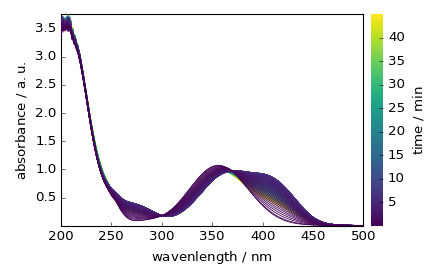

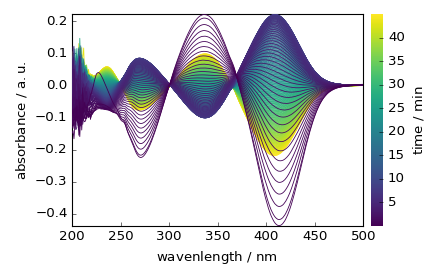

In [8]:
_ = D.plot(colorbar=True)
scp.show()
_ = (D - D.mean(dim=0)).plot(colorbar=True)
scp.show()

In [ ]:
# 2D-COS: synchronous spectrum

cov = scp.NDDataset(np.cov(D.T))
cov.title = 'covariance'
cov.set_coordset(D.x, D.x)
cov.preferences.figure.figsize = (6., 5.)
cov[:450.,:450.].plot(method="image", image_cmap="viridis", colorbar=True)

scp.show()


In [ ]:
# PCA, 5 components

pca = scp.PCA(n_components=5)
pca.fit(D)
pca.loadings.plot()
scp.show()
pca.scores.T.plot()
scp.show()
pca.printev()

In [ ]:
# %%
_ = pca.scoreplot(1,2)
scp.show()
_ = pca.scoreplot(1,2,3)
scp.show()

In [ ]:
# Reconstruction of the spectra with the first component (#0)

Dhat = scp.dot(pca.scores[:,0], pca.loadings[0]) + dmean.data
D.plot(cmap=None, color='dodgerblue')
ax = dhat.plot(cmap=None, color='limegreen', clear=False)
(dexp - dhat).plot(clear=False, cmap=None, color='lightcoral')
ax.set_ylim(-0.2, 4)
scp.show()


In [ ]:
# %% add the second component

Dhat += scp.dot(pca.scores[:,1], pca.loadings[1])
D.plot(cmap=None, color='dodgerblue')
ax = Dhat.plot(cmap=None, color='limegreen', clear=False)
(D - Dhat).plot(clear=False, cmap=None, color='lightcoral')
ax.set_ylim(-0.2, 4)
scp.show()

In [ ]:
# Evolving Factor Analysis with 3 compoenets
efa = scp.EFA(n_components=3)
efa.fit(dexp)

# plot Forward and reverse
np.log10(efa.f_ev.clip(1e-5)).T.plot(cmap=None, color='dodgerblue')
np.log10(efa.b_ev.clip(1e-5)).T.plot(clear=False, cmap=None, color='limegreen')
scp.show()

In [ ]:
#%% get anf plot concentration profile
C = efa.transform()
_ = C.T.plot()


In [ ]:
# Introduction to SIMPLISMA: get the purity spectrum

p = D.std(dim=0)/(D.mean(dim=0) + 0.03 * np.mean(D))
p.plot()
scp.show()

In [ ]:
# perform unsupervised simplisma with 3 (or less) components
sim = scp.SIMPLISMA(n_components=3, tol=0.1)
sim.fit(dexp)

# and plot spectra
sim.St.plot()
scp.show()

In [ ]:
# MCR ALS, 2 componnents, first and last spectrum as guess

mcr_0 = scp.MCRALS(log_level='INFO')
St0 = scp.concatenate((dexp[0], dexp[-1]), axis=0)
mcr_0 = mcr_0.fit(dexp, St0)

mcr_0.C.T.plot(); scp.show()
mcr_0.St.plot(); scp.show()
mcr_0.plotmerit(nb_traces=5); scp.show()

In [ ]:
# MCR ALS, 3 componnents, first, intermediate and last spectrum as guess

mcr_1 = scp.MCRALS(log_level='INFO')
mcr_1.solverConc = 'nnls'
mcr_1.closureConc = [0,1,2]
St0 = scp.concatenate((dexp[0], dexp[len(dexp.y)//2], dexp[-1]), axis=0)
St0.plot(title="guess spectra"); scp.show()
mcr_1 = mcr_1.fit(dexp, St0)


mcr_1.C.T.plot(); scp.show()
mcr_1.St.plot(); scp.show()
mcr_1.plotmerit(nb_traces=5)
scp.show()

In [ ]:
# MCR ALS, 3 componnents, intensities as guess

C0 = scp.concatenate((dexp[:,340.], dexp[:,260.], dexp[:,240.]), axis=1)
C0.T.plot(title="Intensities, guess concentrations")

mcr_2 = scp.MCRALS(log_level='INFO')
mcr_2.solverConc = 'nnls'
mcr_2.closureConc = [0,1,2]
mcr_2 = mcr_2.fit(dexp, C0)

mcr_2.C.T.plot()
scp.show()
mcr_2.St.plot()
ax = mcr_2.plotmerit(nb_traces=10)

In [ ]:
# MCR ALS, 3 componnents, EFA

efa = scp.EFA(n_components=3)
efa.fit(dexp)
C0 = efa.transform()
C0.T.plot(title='EFA guess concentrations')
scp.show()

mcr_3 = scp.MCRALS(log_level='INFO')
mcr_3.solverConc = 'nnls'
mcr_3.closureConc = [0,1,2]
mcr_3 = mcr_2.fit(dexp, C0)

mcr_3.C.T.plot(); scp.show()
mcr_3.St.plot(); scp.show()
mcr_3.plotmerit(nb_traces=5); scp.show()


In [ ]:
# MCR-ALS with kinetic constraints

# setup initial model
reactions = ("A -> B", "B -> C")
species_concentrations = {"A": 1.0, "B": 0.0, "C": 0.0}
k0 = np.array((0.5, 0.05))
kin = scp.ActionMassKinetics(reactions, species_concentrations, k0)
Ckin = kin.integrate(D.y.data)

# compare concentrations
_ = mcr_3.C.T.plot()
_ = Ckin.T.plot(clear=False, ls='dashed')


In [ ]:
# Performs MCR-ALS

param_to_optimize = {"k[0]": 0.5, "k[1]": 0.05}
mcr_5 = scp.MCRALS()
mcr_5.hardConc = [0, 1, 2]
mcr_5.getConc = kin.fit_to_concentrations
mcr_5.argsGetConc = ([0, 1, 2], [0, 1, 2], param_to_optimize)
mcr_5.kwargsGetConc = {"ivp_solver_kwargs": {"return_NDDataset": False}}

mcr_5.fit(D, Ckin)

# %%
_ = mcr_5.C.T.plot()
_ = mcr_5.C_constrained.T.plot(clear=False, ls='dashed')
scp.show()

# %%
mcr_5.St.plot()
scp.show()
ax = mcr_5.plotmerit(colors=('dodgerblue','limegreen', 'lightcoral'), ls='solid', cmap=None)


In [ ]:
# Final model, reversible reactions

reactions = ("A -> B", "B -> A", "B -> C")
species_concentrations = {"A": 1.0, "B": 0.0, "C": 0.0}
k0 = np.array((0.25, 0.05, 0.04))
kin = scp.ActionMassKinetics(reactions, species_concentrations, k0)

Ckin = kin.integrate(D.y.data)
_ = mcr_5.C.T.plot()
_ = Ckin.T.plot(clear=False, ls='dashed')

param_to_optimize = {"k[0]": 0.25, "k[1]": 0.05, "k[2]": 0.04}
mcr_6 = scp.MCRALS()
mcr_6.hardConc = [0, 1, 2]
mcr_6.getConc = kin.fit_to_concentrations
mcr_6.argsGetConc = ([0, 1, 2], [0, 1, 2], param_to_optimize)
mcr_6.kwargsGetConc = {"ivp_solver_kwargs": {"return_NDDataset": False}}

mcr_6.fit(D, Ckin)

# %%
_ = mcr_6.C.T.plot()
_ = mcr_6.C_constrained.T.plot(clear=False, ls='dashed')

# %%
mcr_5.St.plot()
scp.show()

# %%
ax = mcr_5.plotmerit(nb_traces=10)